# Study of Rates 

This notebook utilizes data kindly made available by the JHU Systems Group at 
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%m/%d/%y"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

In [3]:
# Tools specific to the notebook analysis

# Preprocssing and Cleaning

def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def get_countries(raw_world):
    """Country level metadata from the raw source"""
    res = raw_world.select(['Country/Region', 'Lat', 'Long']).group('Country/Region', np.mean)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-5])
    return res

# Computing rates of growth

def wgmean(vals):
    xvals = [x for x in vals if np.isfinite(x)]
    try :
        return scipy.stats.gmean(xvals) if xvals else np.nan
    except :
        return np.nan

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return wgmean(trend['rate'][-window:])

def growth_rate(trend, val='rate', window=1):
    """Smooth raw rates"""
    rates = trend[val]
    #vals = np.array((window-1)*[np.nan] + list(rates))
    #return [wgmean(vals[i:i+window]) for i in range(len(rates))]
    return [wgmean(rates[max(0,i-window) : i+window+1]) for i in range(len(rates))]

def plot_rate_trend(trend, val='rate'):
    with np.errstate(divide='ignore', invalid='ignore'):
        trend = trend.with_column('gm_rate', growth_rate(trend, val))
        trend.extract(['gm_rate']).oplot(height=8, width=8, xlab=20)
        trend.plots[-1].scatter(trend['date'], trend[val])
    



# Modeling

def get_rates(ts, val='arate'):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if val in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

def exp_rate(days, s, r):
    return [s*r**day for day in days]

def lin_rate(days, s, r):
    return [s + r*day for day in days]

def fit(model, trend, val='arate'):
    """Fit a 2 paramater model to a rate trend"""
    try :
        doffs = list(range(trend.num_rows))
        params, pcov = scipy.optimize.curve_fit(model, doffs, trend[val])
        return params, np.sqrt(np.diag(pcov))
    except :
        return [np.nan, np.nan], [np.nan, np.nan]

def model_rate_trend(trend, val='arate'):
    eparams, epcov = fit(exp_rate, trend, val)
    doffs = list(range(trend.num_rows))
    t1 = trend.with_column('exp pred', exp_rate(doffs, eparams[0], eparams[1]))
    lparams, lpcov = fit(lin_rate, trend)
    t2 = t1.with_column('lin pred', lin_rate(doffs, lparams[0], lparams[1]))
    return t2, eparams, lparams

def show_model_rate_trend(trend, val='arate'):
    mtrend, eparams, lparams = model_rate_trend(trend, val)
    print(eparams, lparams)
    mtrend.extract(['exp pred', 'lin pred']).oplot(width=8, xlab=25)
    mtrend.plots[-1].scatter(mtrend['date'], mtrend[val])

def project_progressive_trend(trend, region, num_days, fit_start=None, fit_end=None, distance=14):
    day = trend.last(trend.time_column)
    old_day = inc_day(day, -distance)
    val = trend.last(region)
    new = trend.last('new')
    active = trend.last('active')
    arate = trend.last('arate')
    if fit_start :
        if fit_end is None :
            fit_end = day 
        params, pcov = fit(exp_rate, trend.between(fit_start, fit_end), 'arate')
    else :
        params, pcov = fit(exp_rate, trend, 'arate')
    growths = exp_rate(range(num_days+1), arate, params[1])
    
    proj = trend.select([trend.time_column, region, 'new', 'active', 'arate'])
    for i in range(num_days):
        day = inc_day(day)
        old_day = inc_day(old_day)
        arate = growths[i+1]
        new = arate*active
        val = val + new
        active = active + new - proj.get(old_day, 'new')
        proj.append((day, val, new, active, arate))
    return proj

def proj_prog(trend, region, dist=14, fit_start=None, fit_end=None):
    proj = project_progressive_trend(trend, region, dist, fit_start, fit_end)
    pproj = proj.extract([region, 'active', 'new'])
    pproj.oplot(width = 8, xlab=25)
    end = trend.last(trend.time_column)
    plots.plot([end, end], [0, trend.last(region)])
    if fit_start:
        plots.plot([fit_start, fit_start], [0, trend.get(fit_start, region)], ':')
    if fit_end:
        plots.plot([fit_end, fit_end], [0, trend.get(fit_end, region)], ':')
    plots.text(end, trend.last(region), "{:,}".format(trend.last(region)))
    plots.text(pproj.last('date'), pproj.last(region), "{:,}".format(int(pproj.last(region))))

In [4]:
# Projections

def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj
    
def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(ts.extract(region).tail(7+prev).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(ts.extract(region).tail(7, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    proj.tail(dist).show()
    proj.select(['date', region, 'new']).tail(prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=6)
    plots.plot([end, end], [0, combined[region][-1]])
    pname = make_pname(region, prev)
    plots.plot([pend, pend], [0, combined[pname][-1]])
    plots.text(end, combined[region][-dist], "{:,}".format(int(combined[region][-dist])))
    plots.text(end, combined[region][-1], "{:,}".format(int(combined[region][-1])))
    plots.text(pend, combined[region][-dist-prev], "{:,}".format(int(combined[region][-dist-prev])))
    plots.text(pend, combined[pname][-1], "{:,}".format(int(combined[pname][-1])))
    combined.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))
    _ = plots.xticks(rotation=90)
    

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [5]:
worldCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 
raw_states_cases = Table.read_table(worldCasesURL)
cases_by_state = by_state_cases(raw_states_cases)
cases = TimeTable.transpose(cases_by_state, 'Country/Region', time_col='date', time_less = less_day, time_inc = inc_day)
countries = get_countries(raw_states_cases)
# Last day of rerported data
last_day = cases['date'][-1]
last_day, countries.num_rows

('04/27/20', 185)

## World-wide picture

The following graph shows the national picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

In [6]:
def label_val(trend, x, val):
    x_val = trend.get(x, trend.time_column)
    y_val = trend.get(x, val)
    plots.text(x_val, y_val, "{:,}".format(y_val))

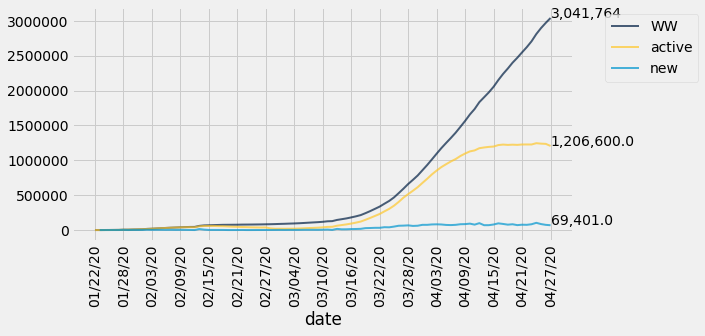

In [7]:
WW_cases = cases.select(cases.time_column)
WW_cases['WW'] = cases.sum_cols()
WW_case_trend = WW_cases.trend()
WW_case_trend.extract(['WW', 'active', 'new']).oplot(width=8, xlab=20)
label_val(WW_case_trend, last_day, 'WW')
label_val(WW_case_trend, last_day, 'active')
label_val(WW_case_trend, last_day, 'new')

In [8]:
def add_line(trend, x, col, y, text):
    my = np.nanmin(trend[col])
    plots.plot([x, x],[my, y], ":")
    plots.text(x, y, text)

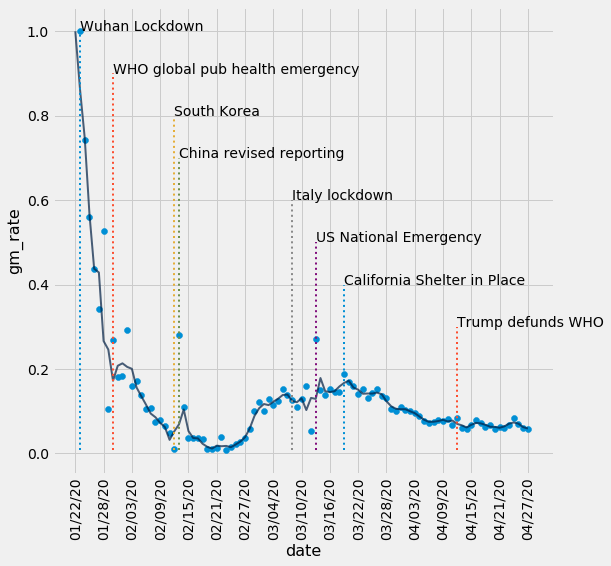

In [9]:
plot_rate_trend(WW_case_trend, 'arate')
add_line(WW_case_trend, "01/23/20", 'arate', 1, "Wuhan Lockdown")
add_line(WW_case_trend, "01/30/20", 'arate', 0.9, "WHO global pub health emergency")
add_line(WW_case_trend, "02/12/20", 'arate', 0.8, "South Korea")
add_line(WW_case_trend, "02/13/20", 'arate', 0.7, "China revised reporting")
add_line(WW_case_trend, "03/08/20", 'arate', 0.6, "Italy lockdown")
add_line(WW_case_trend, "03/13/20", 'arate', 0.5, "US National Emergency")
add_line(WW_case_trend, "03/19/20", 'arate', 0.4, "California Shelter in Place")
add_line(WW_case_trend, "04/12/20", 'arate', 0.3, "Trump defunds WHO")

## Early Warning

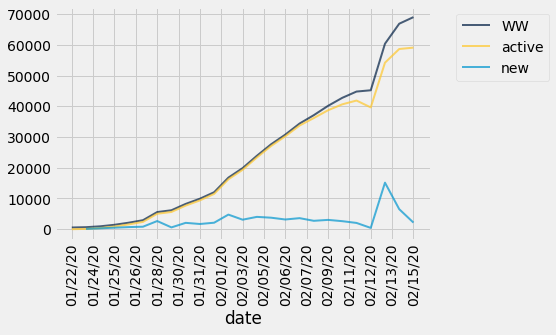

In [10]:
# Three weeks of early warning
WW_case_trend.before("02/15/20").extract(['WW', 'active', 'new']).oplot(xlab=20)

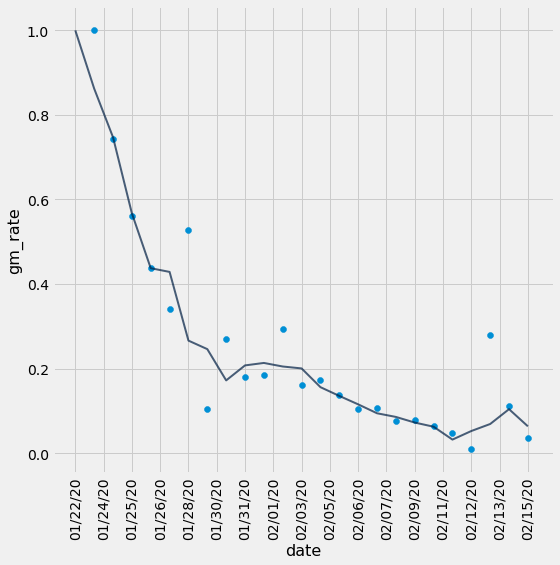

In [11]:
plot_rate_trend(WW_case_trend.before("02/15/20"), 'arate')

## The Lost Month

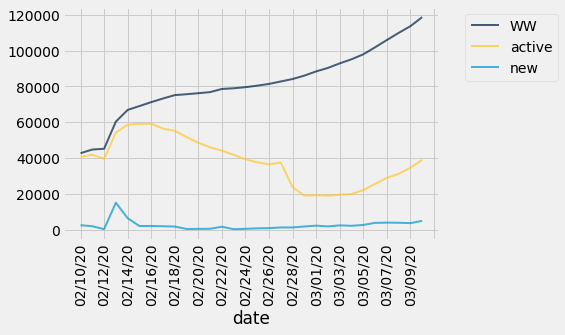

In [12]:
gap = WW_case_trend.after("02/10/20").before("03/10/20")
gap.extract(['WW', 'active', 'new']).oplot(xlab=20)

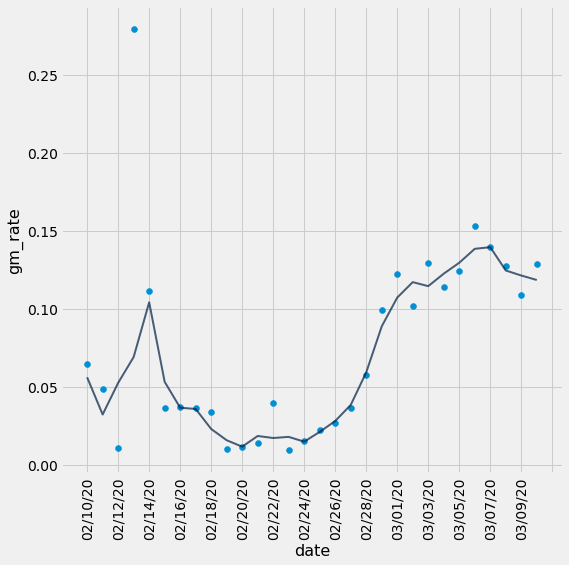

In [13]:
plot_rate_trend(gap, 'arate')

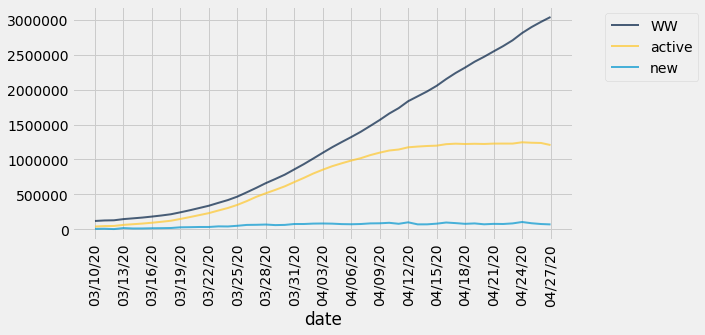

In [14]:
WW_recent = WW_case_trend.after("03/10/20")
WW_recent.extract(['WW', 'active', 'new']).oplot(width=8, xlab=20)

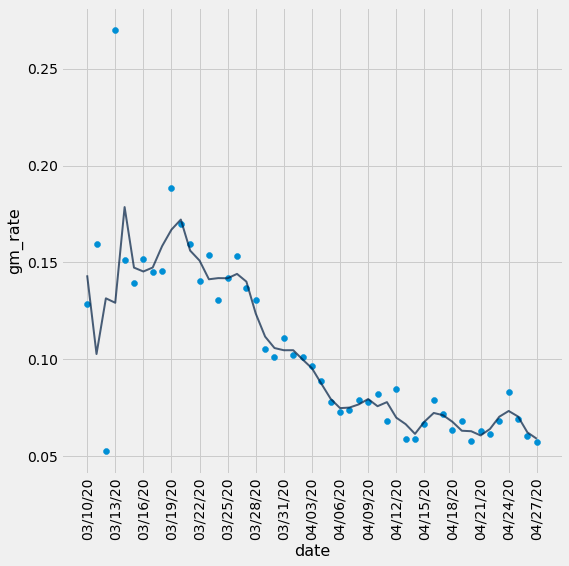

In [15]:
plot_rate_trend(WW_recent, 'arate')

[0.17484754 0.97698131] [ 0.16471939 -0.00247569]


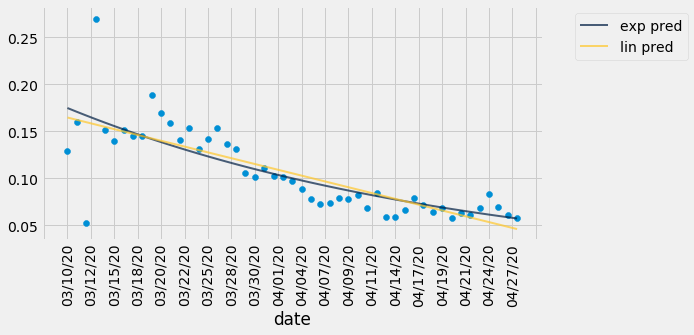

In [16]:
show_model_rate_trend(WW_recent)

[0.14287316 0.95709478] [ 0.13590388 -0.00407526]


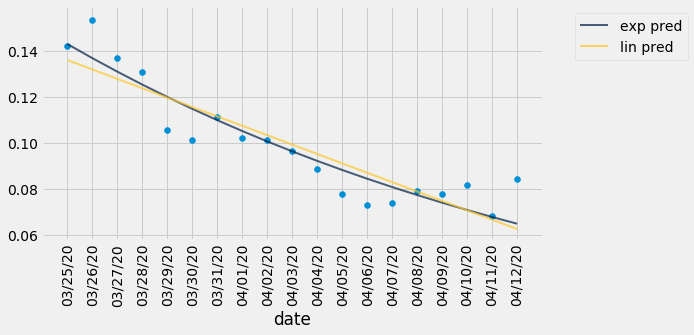

In [17]:
show_model_rate_trend(WW_case_trend.between("03/25/20", "04/12/20"))

[0.06998687 0.99423122] [ 0.06993245 -0.0003858 ]


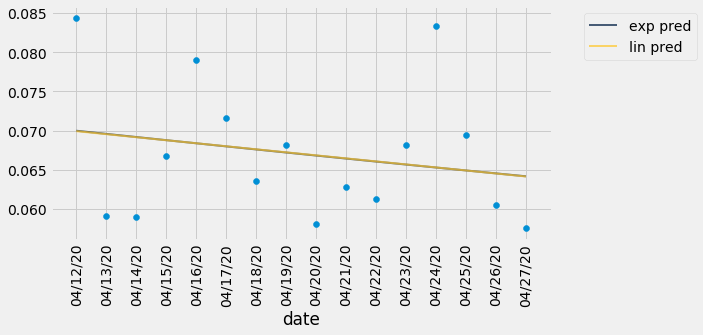

In [18]:
show_model_rate_trend(WW_case_trend.after("04/12/20"))

In [19]:
def proj_WW(start=7, end=0, dist=14):
    fit_start = inc_day(last_day, -start)
    end = min(end, start)
    fit_end = inc_day(last_day, -end)
    proj_prog(WW_recent, 'WW', dist, fit_start=fit_start, fit_end=fit_end)

interact(proj_WW, start=(7, 21, 1), end=(0, 14, 1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=7), IntSlider(value=0, description='…

<function __main__.proj_WW(start=7, end=0, dist=14)>

In [20]:
US_cases = cases.extract('US')
US_trend = US_cases.trend()
China_cases = cases.extract('China')
China_trend = China_cases.trend()

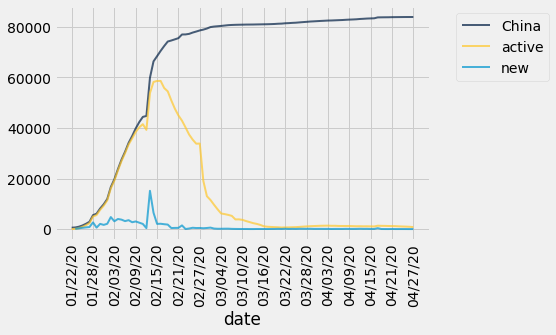

In [21]:
China_trend.extract(['China', 'active', 'new']).oplot(xlab=20)

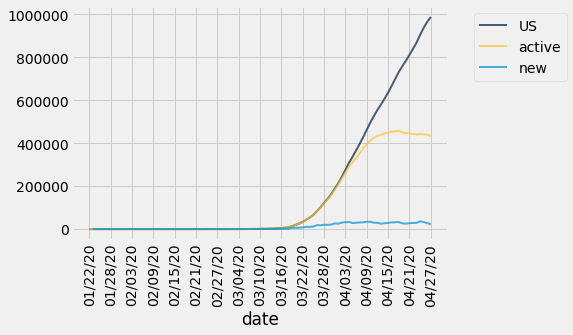

In [22]:
US_trend.extract(['US', 'active', 'new']).oplot(xlab=20)

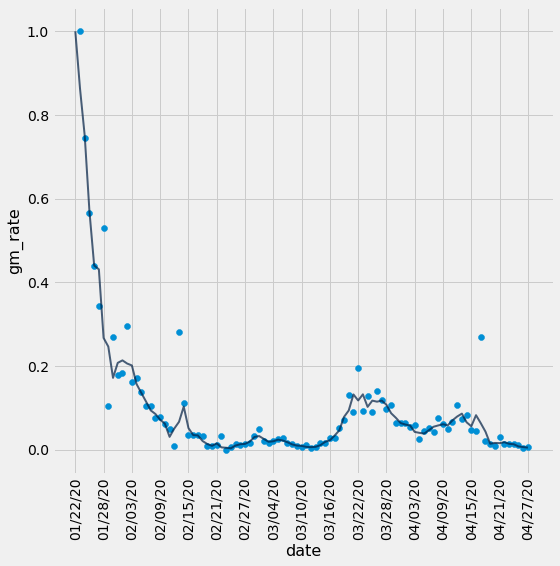

In [23]:
plot_rate_trend(China_trend, 'arate')

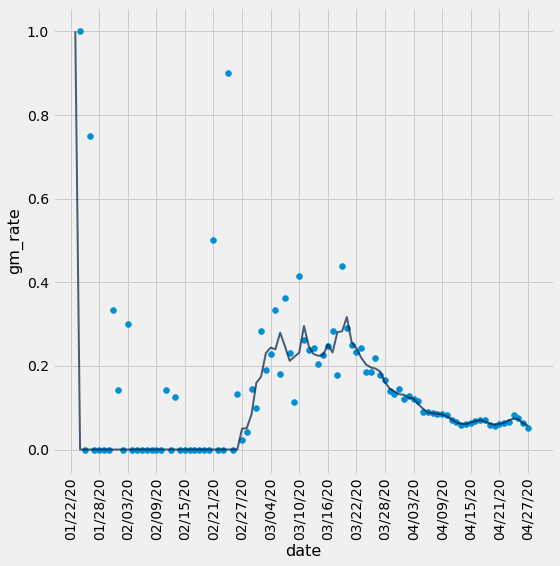

In [24]:
plot_rate_trend(US_trend, 'arate')

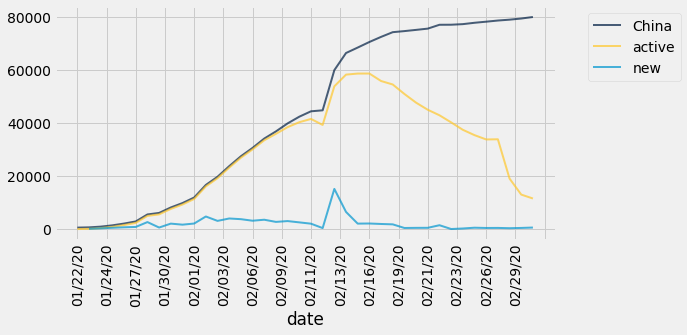

In [25]:
China_trend.before('03/01/20').extract(['China', 'active', 'new']).oplot(width=8, xlab=20)

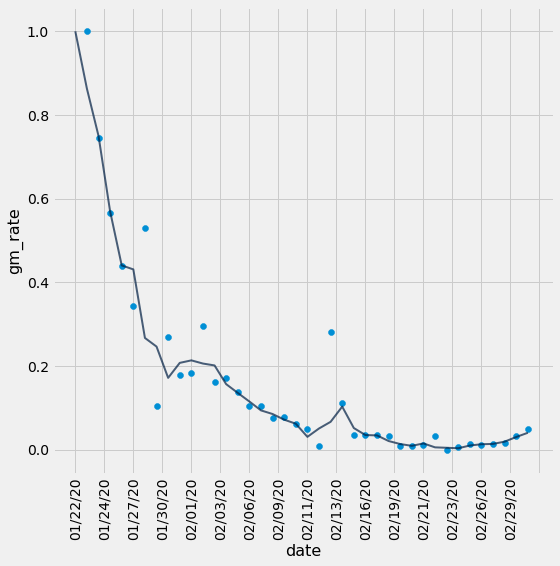

In [26]:
plot_rate_trend(China_trend.before('03/01/20'), 'arate')

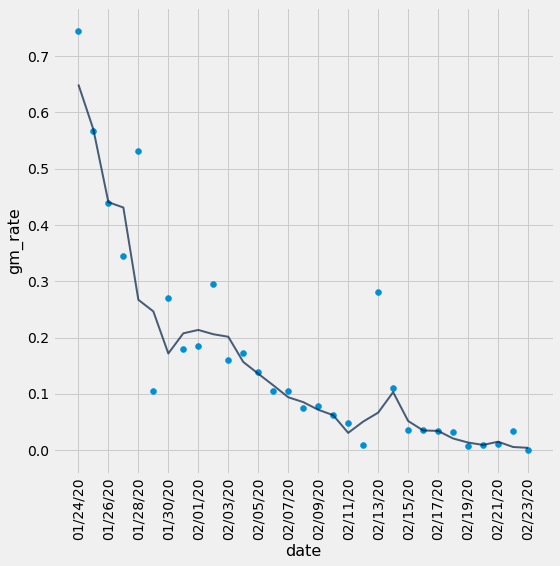

In [27]:
plot_rate_trend(China_trend.between('01/24/20', "02/23/20"), 'arate')

[0.6457142  0.87202035] [ 0.41298505 -0.01633425]


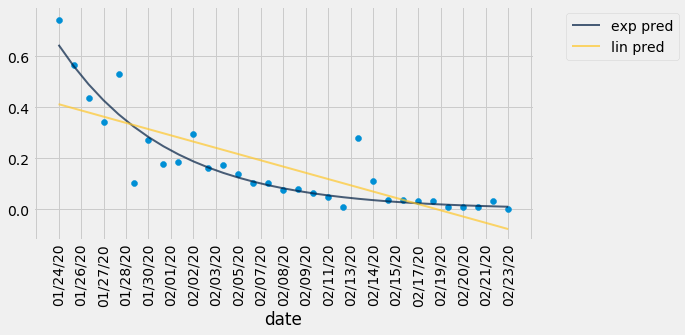

In [28]:
show_model_rate_trend(China_trend.between('01/24/20', "02/23/20"))

[0.04890686 1.00317603] [0.0466639  0.00024252]


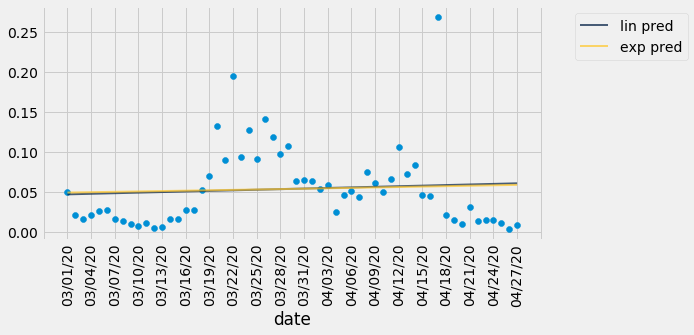

In [29]:
show_model_rate_trend(China_trend.after("03/01/20"))

[0.06950209 0.97407859] [ 0.07303772 -0.00176578]


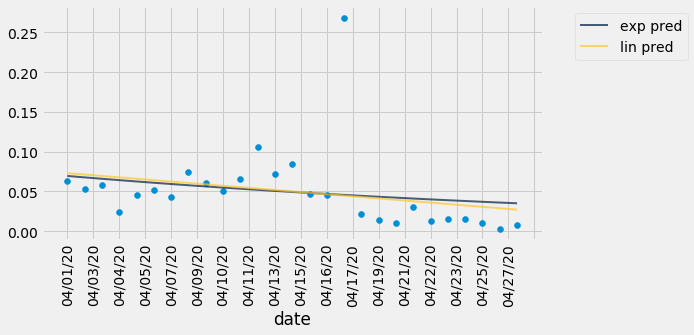

In [30]:
show_model_rate_trend(China_trend.after("04/01/20"))

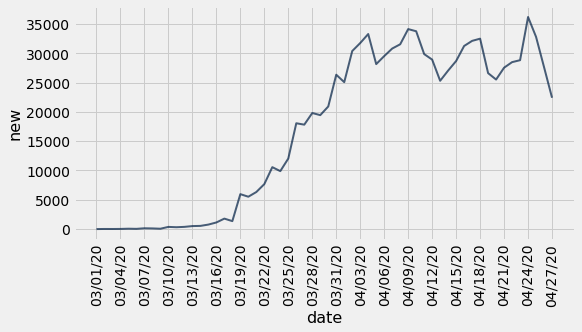

In [31]:
US_trend.extract('new').after('03/01/20').oplot(width=8, xlab=25)

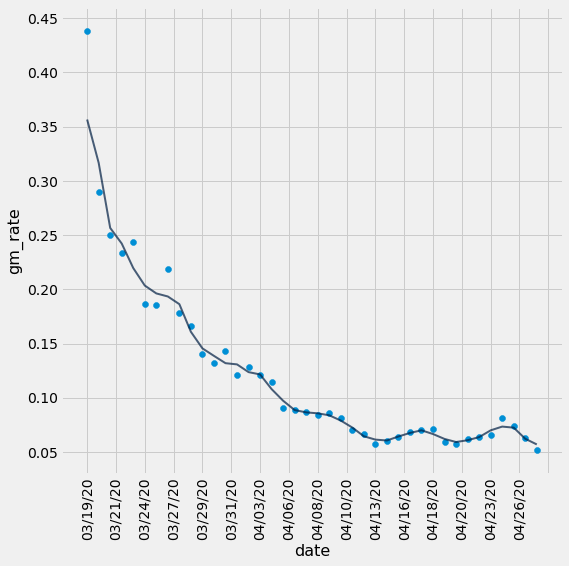

In [32]:
plot_rate_trend(US_trend.after("03/19/20"), 'arate')

[0.31233775 0.93995705] [ 0.2361457  -0.00580325]


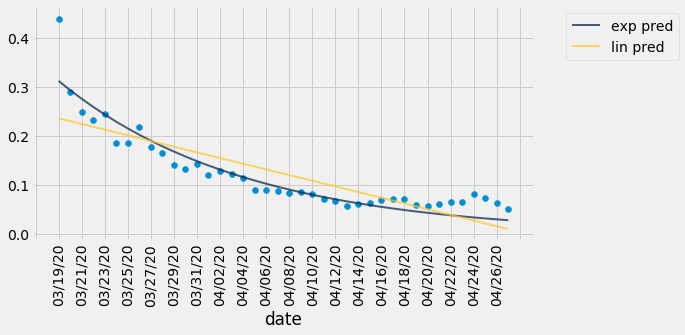

In [33]:
show_model_rate_trend(US_trend.after("03/19/20"))

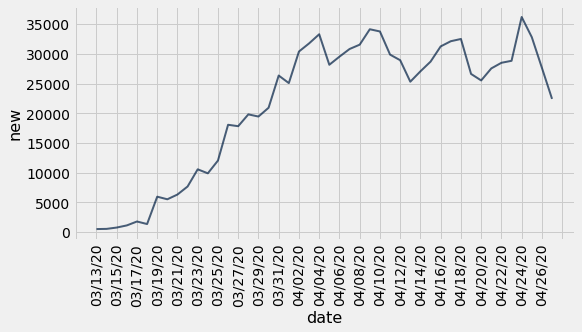

In [34]:
US_trend.extract(['new']).after('03/13/20').oplot(width=8, xlab=25)

https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html

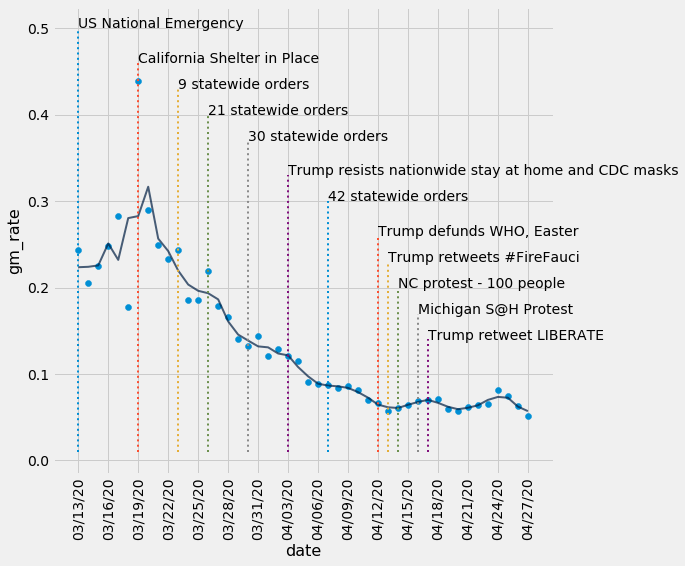

In [35]:
plot_rate_trend(US_trend.after("03/13/20"), 'arate')
add_line(WW_case_trend, "03/13/20", 'arate', 0.5, "US National Emergency")
add_line(WW_case_trend, "03/19/20", 'arate', 0.46, "California Shelter in Place")
add_line(WW_case_trend, "03/23/20", 'arate', 0.43, "9 statewide orders")
add_line(WW_case_trend, "03/26/20", 'arate', 0.40, "21 statewide orders")
add_line(WW_case_trend, "03/30/20", 'arate', 0.37, "30 statewide orders")
add_line(WW_case_trend, "04/03/20", 'arate', 0.33, "Trump resists nationwide stay at home and CDC masks")
add_line(WW_case_trend, "04/07/20", 'arate', 0.30, "42 statewide orders")
add_line(WW_case_trend, "04/12/20", 'arate', 0.26, "Trump defunds WHO, Easter")
add_line(WW_case_trend, "04/13/20", 'arate', 0.23, "Trump retweets #FireFauci")
add_line(WW_case_trend, "04/14/20", 'arate', 0.20, "NC protest - 100 people")
add_line(WW_case_trend, "04/16/20", 'arate', 0.17, "Michigan S@H Protest")
add_line(WW_case_trend, "04/17/20", 'arate', 0.14, "Trump retweet LIBERATE")

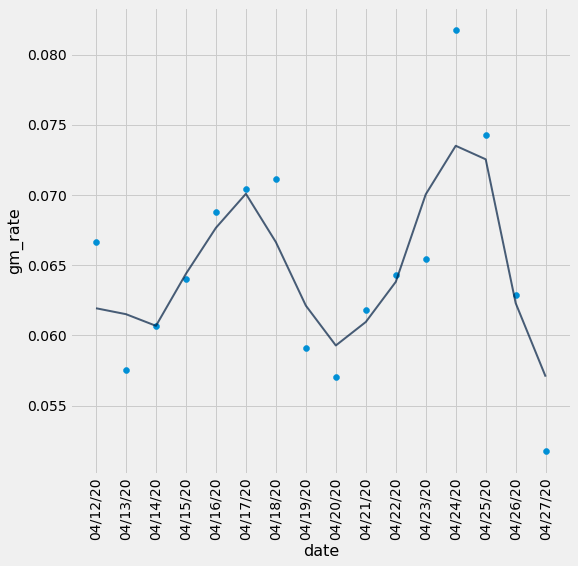

In [36]:
plot_rate_trend(US_trend.after("04/12/20"), 'arate')

[0.06407379 1.00158925] [0.06405507 0.00010508]


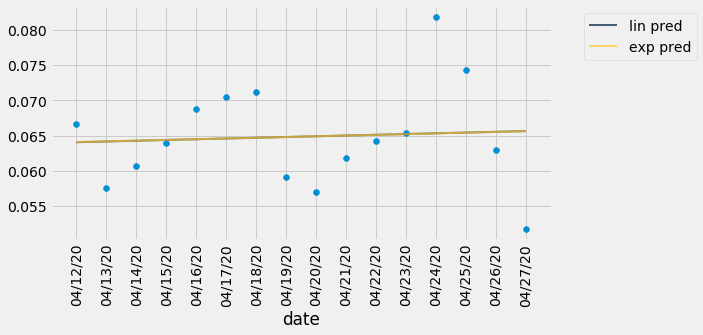

In [37]:
show_model_rate_trend(US_trend.after("04/12/20"))

In [38]:
US_recent = US_trend.after("03/13/20")

In [39]:
def proj_US(start=7, end=0, dist=14):
    fit_start = inc_day(last_day, -start)
    end = min(end, start)
    fit_end = inc_day(last_day, -end)
    proj_prog(US_recent, 'US', dist, fit_start=fit_start, fit_end=fit_end)

[0.31233775 0.93995705] [ 0.2361457  -0.00580325]


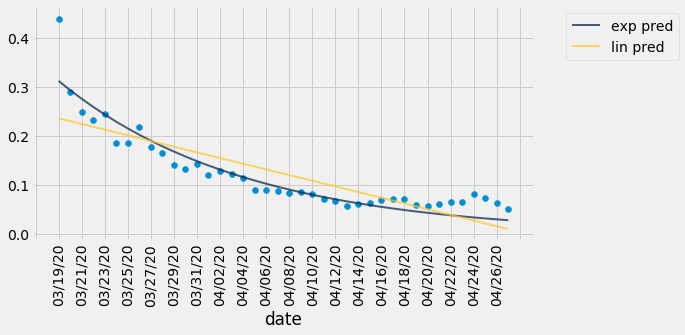

In [40]:
show_model_rate_trend(US_trend.after("03/19/20"), 'arate')

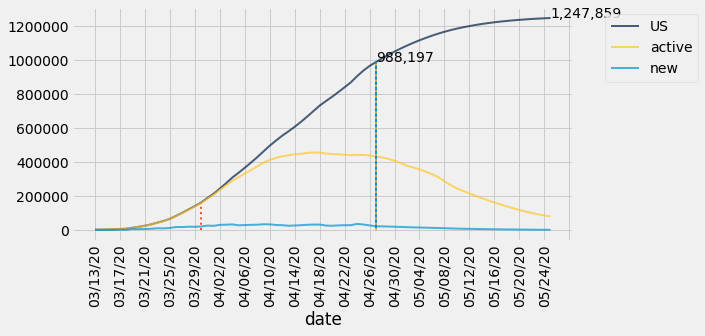

In [41]:
# Current picture using the last month as basis for prediction
proj_US(start=28, dist=28)

[0.06531951 0.99970275] [ 6.53205367e-02 -1.95159666e-05]


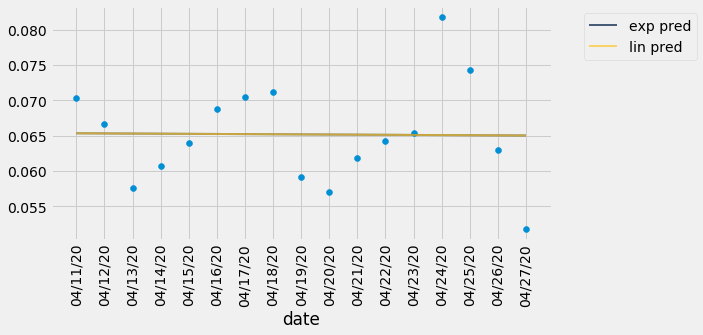

In [42]:
show_model_rate_trend(US_trend.after("04/11/20"), 'arate')

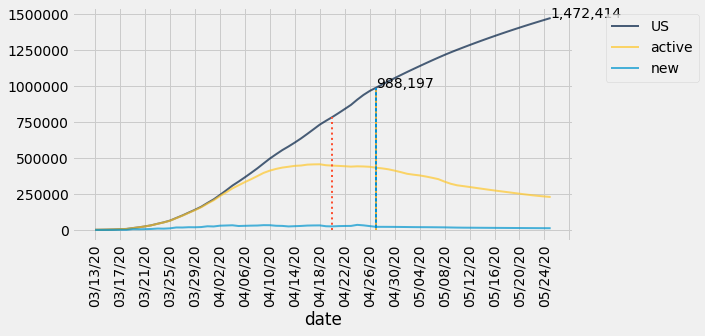

In [43]:
# Current picture using the last week as basis for prediction
proj_US(start=7, dist=28)

[0.115069   0.94176644] [ 0.11280012 -0.00528901]


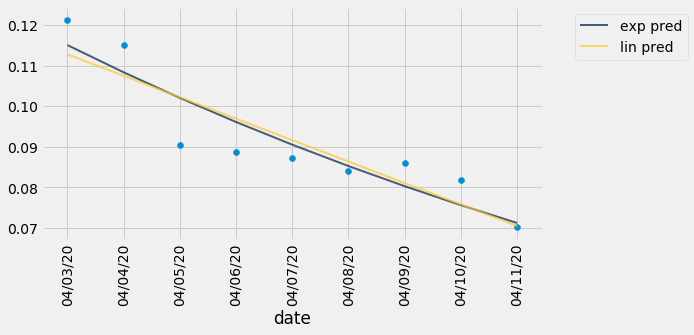

In [44]:
show_model_rate_trend(US_trend.between("04/03/20", "04/11/20"), 'arate')

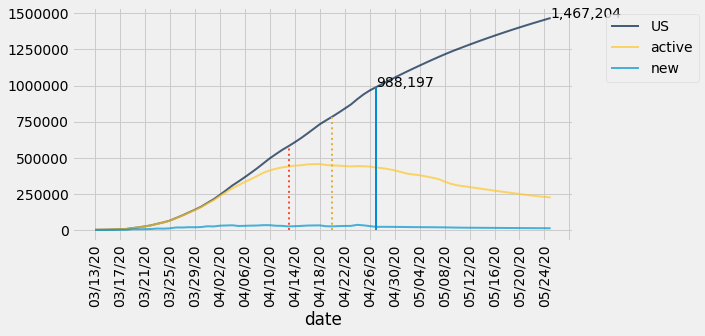

In [45]:
# How it would look if things were still improving like they were the week before
proj_US(start=14, end=7, dist=28)

[0.063513   1.00268929] [0.06346753 0.00017929]


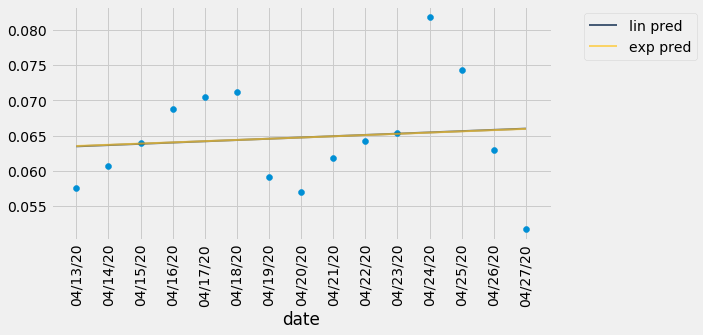

In [46]:
show_model_rate_trend(US_trend.after("04/13/20"), 'arate')

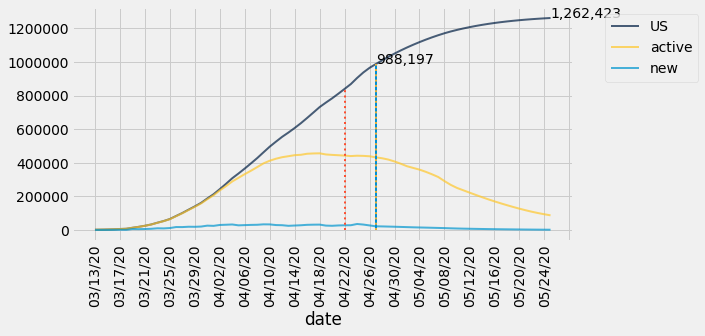

In [47]:
# Current picture using the last 5 days as basis for prediction
proj_US(start=5, dist=28)

In [48]:
interact(proj_US, start=(5, 21, 1), end=(0, 14, 1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=5), IntSlider(value=0, description='…

<function __main__.proj_US(start=7, end=0, dist=14)>

<a id=sectionCases></a>
## Cases to date by state

The following shows the national picture built up state by state.  Only the largest are shown, with the remainder
grouped into 'other'.

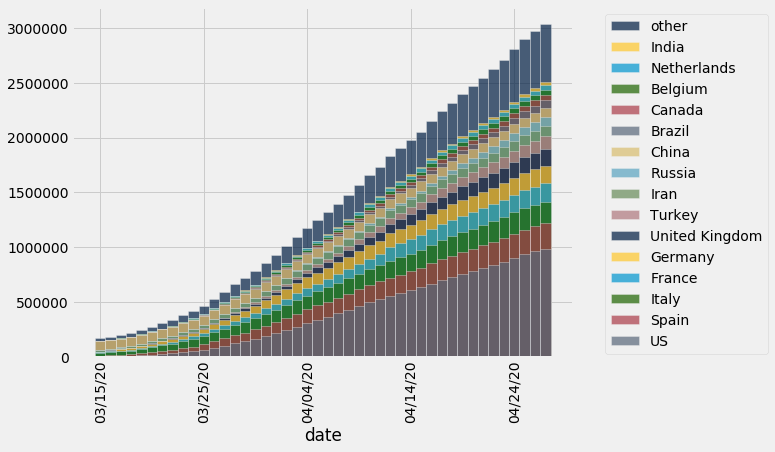

In [49]:
# Total US cases broken down by Country
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

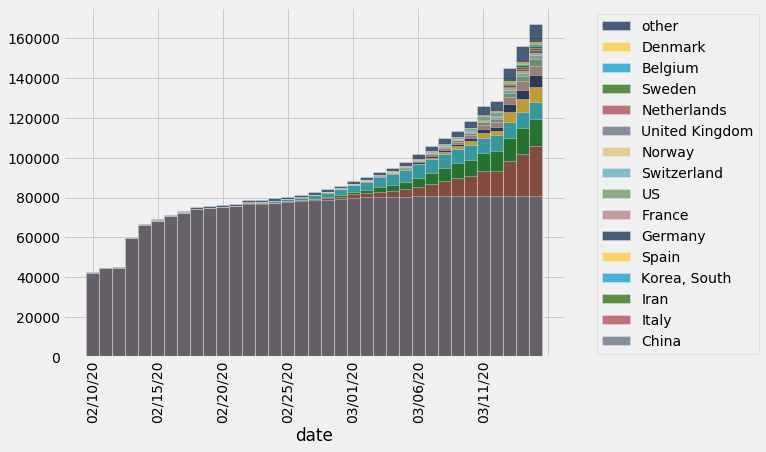

In [50]:
# What the world picture looked like during the lost month
cases.after("02/10/20").before("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

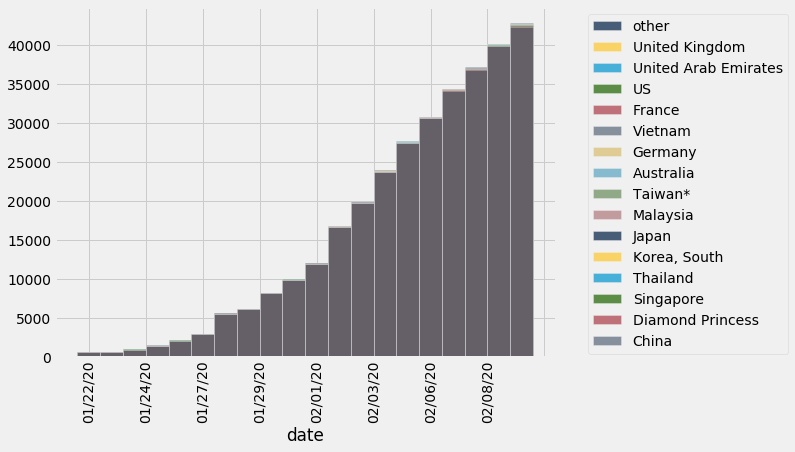

In [51]:
# And during the early warning period
cases.before("02/10/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

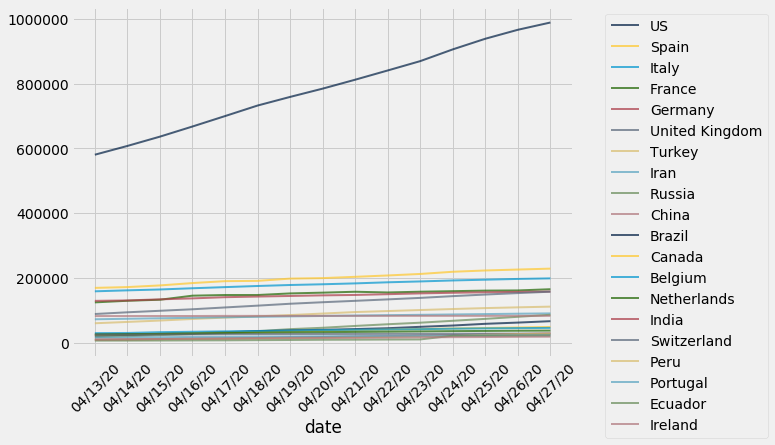

In [52]:
# Cases by state over the past two weeks
cases.top(20).tail(14).plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

In [53]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, limit=None, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            if limit :
                vals = vals[:limit]
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

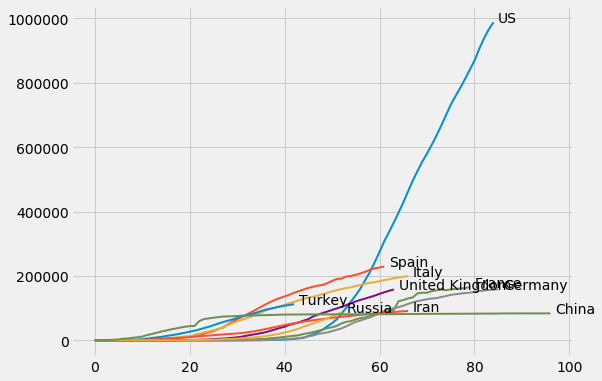

In [54]:
show_cases_since(cases.top(10), 10)

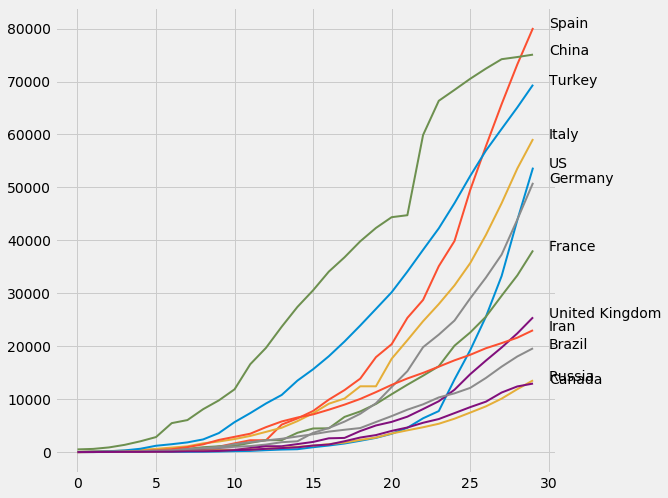

In [55]:
show_cases_since(cases.top(12), 40, 30, height=8)

<a id='sectionTrends'></a>
## Growth trends by country

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [56]:
cases.order_cols().trend().tail(7)

date     | US     | new US | %new US   | rate US | active US | arate US  | Spain  | new Spain | %new Spain | rate Spain | active Spain | arate Spain | Italy  | new Italy | %new Italy | rate Italy | active Italy | arate Italy | France | new France | %new France | rate France | active France | arate France | Germany | new Germany | %new Germany | rate Germany | active Germany | arate Germany | United Kingdom | new United Kingdom | %new United Kingdom | rate United Kingdom | active United Kingdom | arate United Kingdom | Turkey | new Turkey | %new Turkey | rate Turkey | active Turkey | arate Turkey | Iran  | new Iran | %new Iran | rate Iran | active Iran | arate Iran | Russia | new Russia | %new Russia | rate Russia | active Russia | arate Russia | China | new China | %new China  | rate China | active China | arate China | Brazil | new Brazil | %new Brazil | rate Brazil | active Brazil | arate Brazil | Canada | new Canada | %new Canada | rate Canada | active Canada | arate Canada | Belgium | new Belgium | %new Belgium | rate Belgium | active Belgium | arate Belgium | Netherlands | new Netherlands | %new Netherlands | rate Netherlands | active Netherlands | arate Netherlands | India | new India | %new India | rate India | active India | arate India | Switzerland | new Switzerland | %new Switzerland | rate Switzerland | active Switzerland | arate Switzerland | Peru  | new Peru | %new Peru | rate Peru | active Peru | arate Peru | Portugal | new Portugal | %new Portugal | rate Portugal | active Portugal | arate Portugal | Ecuador | new Ecuador | %new Ecuador | rate Ecuador | active Ecuador | arate Ecuador | Ireland | new Ireland | %new Ireland | rate Ireland | active Ireland | arate Ireland | Sweden | new Sweden | %new Sweden | rate Sweden | active Sweden | arate Sweden | Saudi Arabia | new Saudi Arabia | %new Saudi Arabia | rate Saudi Arabia | active Saudi Arabia | arate Saudi Arabia | Israel | new Israel | %new Israel | rate Israel | active Israel | arate Israel | Mexico | new Mexico | %new Mexico | rate Mexico | active Mexico | arate Mexico | Austria | new Austria | %new Austria | rate Austria | active Austria | arate Austria | Singapore | new Singapore | %new Singapore | rate Singapore | active Singapore | arate Singapore | Japan | new Japan | %new Japan | rate Japan | active Japan | arate Japan | Pakistan | new Pakistan | %new Pakistan | rate Pakistan | active Pakistan | arate Pakistan | Chile | new Chile | %new Chile | rate Chile | active Chile | arate Chile | Poland | new Poland | %new Poland | rate Poland | active Poland | arate Poland | Romania | new Romania | %new Romania | rate Romania | active Romania | arate Romania | Belarus | new Belarus | %new Belarus | rate Belarus | active Belarus | arate Belarus | Qatar | new Qatar | %new Qatar | rate Qatar | active Qatar | arate Qatar | United Arab Emirates | new United Arab Emirates | %new United Arab Emirates | rate United Arab Emirates | active United Arab Emirates | arate United Arab Emirates | Korea, South | new Korea, South | %new Korea, South | rate Korea, South | active Korea, South | arate Korea, South | Indonesia | new Indonesia | %new Indonesia | rate Indonesia | active Indonesia | arate Indonesia | Ukraine | new Ukraine | %new Ukraine | rate Ukraine | active Ukraine | arate Ukraine | Denmark | new Denmark | %new Denmark | rate Denmark | active Denmark | arate Denmark | Philippines | new Philippines | %new Philippines | rate Philippines | active Philippines | arate Philippines | Norway | new Norway | %new Norway | rate Norway | active Norway | arate Norway | Czechia | new Czechia | %new Czechia | rate Czechia | active Czechia | arate Czechia | Australia | new Australia | %new Australia | rate Australia | active Australia | arate Australia | Serbia | new Serbia | %new Serbia | rate Serbia | active Serbia | arate Serbia | Dominican Republic | new Dominican Republic | %new Dominican Republic | rate Dominican Republic | active Dominican Republic | arate Dominican Republic |

In [57]:
def rate_change(ts, region_type, prev=7):
    rates   = get_rates(ts)
    regions = rates.categories
    current = rates.row(-1)[1:]
    older   = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

In [58]:
cases.trend()

date     | Afghanistan | new Afghanistan | %new Afghanistan | rate Afghanistan | active Afghanistan | arate Afghanistan | Albania | new Albania | %new Albania | rate Albania | active Albania | arate Albania | Algeria | new Algeria | %new Algeria | rate Algeria | active Algeria | arate Algeria | Andorra | new Andorra | %new Andorra | rate Andorra | active Andorra | arate Andorra | Angola | new Angola | %new Angola | rate Angola | active Angola | arate Angola | Antigua and Barbuda | new Antigua and Barbuda | %new Antigua and Barbuda | rate Antigua and Barbuda | active Antigua and Barbuda | arate Antigua and Barbuda | Argentina | new Argentina | %new Argentina | rate Argentina | active Argentina | arate Argentina | Armenia | new Armenia | %new Armenia | rate Armenia | active Armenia | arate Armenia | Australia | new Australia | %new Australia | rate Australia | active Australia | arate Australia | Austria | new Austria | %new Austria | rate Austria | active Austria | arate Austria | Azerbaijan | new Azerbaijan | %new Azerbaijan | rate Azerbaijan | active Azerbaijan | arate Azerbaijan | Bahamas | new Bahamas | %new Bahamas | rate Bahamas | active Bahamas | arate Bahamas | Bahrain | new Bahrain | %new Bahrain | rate Bahrain | active Bahrain | arate Bahrain | Bangladesh | new Bangladesh | %new Bangladesh | rate Bangladesh | active Bangladesh | arate Bangladesh | Barbados | new Barbados | %new Barbados | rate Barbados | active Barbados | arate Barbados | Belarus | new Belarus | %new Belarus | rate Belarus | active Belarus | arate Belarus | Belgium | new Belgium | %new Belgium | rate Belgium | active Belgium | arate Belgium | Belize | new Belize | %new Belize | rate Belize | active Belize | arate Belize | Benin | new Benin | %new Benin | rate Benin | active Benin | arate Benin | Bhutan | new Bhutan | %new Bhutan | rate Bhutan | active Bhutan | arate Bhutan | Bolivia | new Bolivia | %new Bolivia | rate Bolivia | active Bolivia | arate Bolivia | Bosnia and Herzegovina | new Bosnia and Herzegovina | %new Bosnia and Herzegovina | rate Bosnia and Herzegovina | active Bosnia and Herzegovina | arate Bosnia and Herzegovina | Botswana | new Botswana | %new Botswana | rate Botswana | active Botswana | arate Botswana | Brazil | new Brazil | %new Brazil | rate Brazil | active Brazil | arate Brazil | Brunei | new Brunei | %new Brunei | rate Brunei | active Brunei | arate Brunei | Bulgaria | new Bulgaria | %new Bulgaria | rate Bulgaria | active Bulgaria | arate Bulgaria | Burkina Faso | new Burkina Faso | %new Burkina Faso | rate Burkina Faso | active Burkina Faso | arate Burkina Faso | Burma | new Burma | %new Burma | rate Burma | active Burma | arate Burma | Burundi | new Burundi | %new Burundi | rate Burundi | active Burundi | arate Burundi | Cabo Verde | new Cabo Verde | %new Cabo Verde | rate Cabo Verde | active Cabo Verde | arate Cabo Verde | Cambodia | new Cambodia | %new Cambodia | rate Cambodia | active Cambodia | arate Cambodia | Cameroon | new Cameroon | %new Cameroon | rate Cameroon | active Cameroon | arate Cameroon | Canada | new Canada | %new Canada | rate Canada | active Canada | arate Canada | Central African Republic | new Central African Republic | %new Central African Republic | rate Central African Republic | active Central African Republic | arate Central African Republic | Chad | new Chad | %new Chad | rate Chad | active Chad | arate Chad | Chile | new Chile | %new Chile | rate Chile | active Chile | arate Chile | China | new China | %new China | rate China | active China | arate China | Colombia | new Colombia | %new Colombia | rate Colombia | active Colombia | arate Colombia | Congo (Brazzaville) | new Congo (Brazzaville) | %new Congo (Brazzaville) | rate Congo (Brazzaville) | active Congo (Brazzaville) | arate Congo (Brazzaville) | Congo (Kinshasa) | new Congo (Kinshasa) | %new Congo (Kinshasa) | rate Congo (Kinshasa) | active Congo (Kinshasa) | arate Congo (Kinshasa) | Costa Rica | new Costa Rica | %new Costa Rica | rate 

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous.  The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse.  Gives a sense of how the measures are working.

In [59]:
def irate(previous=7):
    show_rate_change(cases, 'State', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by state

In [60]:
deaths.top(10).tail(14).plot('date', width=7)
_ = plots.xticks(rotation=45)

NameError: name 'deaths' is not defined

In [ ]:
deaths.order_cols().trend().tail(7)

<a id='sectionOneState'></a>
## Cases in one state

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [ ]:
def show_st(state='US', prev = 7):
    cases.extract(state).trend().tail(prev).show()
    cases.extract(state).trend().extract([state, 'new']).tail(21).plot('date', width=7)
    _ = plots.xticks(rotation=90)
    plot_rate_trend(cases.extract(state).trend().tail(prev))
    _ = plots.xticks(rotation=90)

_ = interact(show_st, state=states, prev = (7, 21, 1))

<a id='sectionProj'></a>
## Projection of cases in one state

To look forward at what the story may be over the coming days, we project forward the recent growth rate.  This may be pessimistic if measures are working and the rate is improving.  But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.

In [ ]:
def proj_st(state='US', dist=14):
    proj(cases, state, 7, dist)
    
_ = interact(proj_st, state=states, dist = (7, 14, 1))

In [ ]:
def proj_prog_st(state='US', dist=14):
    proj_prog(cases.extract(state), state, 7, dist)
    
_ = interact(proj_prog_st, state=states, dist = (7, 31, 1))

<a id='sectionProjDeath'></a>
## Projection of deaths in one state

In [ ]:
def proj_st_deaths(state='US', dist=14):
    proj(deaths, state, 7, dist)

_ = interact(proj_st_deaths, state=states, dist = (7, 14, 1))

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [ ]:
def proj2_st(state='US', prev=2, dist=14):
    proj2(cases, state, prev, dist)
    
_ = interact(proj2_st, state=states, prev=(0,7,1), dist=(3, 14, 1))

In [ ]:
def proj2_st_deaths(state='US', prev=2):
    proj2(deaths, state, prev)
    
_ = interact(proj2_st_deaths, state=states, prev=(0,7,1))

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [ ]:
get_rates(cases).tail(7)

In [ ]:
get_rates(cases).tail(14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

In [ ]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def get_rate_slope(trend, region):
    params, pcov = fit(lin_rate, trend)
    return params[1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions],
    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff rate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err'])).join('state', 
                                                     countries.select(['Country/Region', 'Lat']), 
                                                     'Country/Region')

In [ ]:
case_sum = summary(cases, 'state', states)
case_sum.sort('delta', descending=True)

In [ ]:
case_sum.select('state', 'delta').sort('delta').scatter('state', width=12)
_ = plots.xticks(rotation=90)

In [ ]:
def label_point(summary, country, x, y):
    t = summary.where('state', country)
    if np.isfinite(t[x][0]) and np.isfinite(t[y][0]) :
        plots.text(t[x][0], t[y][0], country)

In [ ]:
case_sum.scatter('current', 'rate')
_ = plots.xticks(rotation=90)

In [ ]:
case_sum.scatter('current', 'delta')

In [ ]:
case_sum.scatter('delta', 'rate')
for c in case_sum.where(case_sum['delta'] > 0.02)['state'] :
    label_point(case_sum, c, 'delta', 'rate')

In [ ]:
case_sum.sort('rate', descending = True).take[:10]

In [ ]:
largest_rate = case_sum.sort('rate', descending = True).take[:15]
largest_rate.scatter('current', 'rate')
for c in largest_rate['state'] :
    label_point(case_sum, c, 'current', 'rate')

In [ ]:
case_sum.scatter('current', 'Lat')
_ = plots.xticks(rotation=90)
for c in case_sum.sort('current', descending = True).take[:10]['state'] :
    label_point(case_sum, c, 'current', 'Lat')

In [ ]:
case_sum.scatter('rate', 'Lat')
_ = plots.plot([min(case_sum['rate']),max(case_sum['rate'])], [23.5, 23.5])
_ = plots.plot([min(case_sum['rate']),max(case_sum['rate'])], [-23.5, -23.5])

In [ ]:
case_sum.scatter('delta', 'Lat')
_ = plots.plot([min(case_sum['delta']), max(case_sum['delta'])], [23.5, 23.5])
_ = plots.plot([min(case_sum['delta']), max(case_sum['delta'])], [-23.5, -23.5])

In [ ]:
case_sum.sort('rate', descending=True).take[:20]

In [ ]:
case_sum.sort('delta', descending=True).take[:20]